In [3]:
import time
import os
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle
from numpy import array
####

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
###
from sklearn.utils.class_weight import compute_class_weight


#Models

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


#Model Performance Evaluators
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

from sklearn.datasets import make_classification
from sklearn.metrics import log_loss
from joblib import parallel_backend
from joblib import Parallel, delayed



import matplotlib.pyplot as plt
import numpy as np


import dask
from dask.distributed import Client, progress, LocalCluster, SSHCluster,wait
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from PyALE import ale

In [2]:
#import data

comb_t4_df= pd.read_csv('/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/FR_DCL/train/data_sets/fr_dcl_tr_t4_set4_df.txt',header=0,sep='\t')


np.shape(comb_t4_df)


shuf_comb_t4_df=comb_t4_df.iloc[np.random.permutation(len(comb_t4_df))]


#reset index
shuf_t4_dinuc_df=shuf_comb_t4_df.reset_index(drop=True)




In [3]:
#drop seq_id
shuf_comb_t4_dfdrp= shuf_comb_t4_df.drop(['seq_id'],axis=1)
#shuf_comb_t4_dfdrp=shuf_comb_t4_dfdrp.reset_index(drop=True)
shuf_comb_t4_dfdrp.head()

,5p,3p,strand,ptype,length,AAAA,AAAC,AAAG,AAAT,AACA,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
1922252,716,4841,1,0,4147,23,5,18,8,13,...,17,15,13,8,11,8,4,12,8,8
2756393,710,4838,1,0,319,18,2,2,4,2,...,0,4,0,0,2,5,0,3,3,6
608514,4629,4864,1,1,253,9,1,2,5,2,...,0,3,1,0,3,7,0,3,4,8
2493605,4643,4841,1,0,226,28,2,1,4,2,...,0,3,1,0,2,5,0,3,3,6
1319886,3897,4842,1,1,955,15,3,6,7,6,...,5,4,8,1,4,4,0,6,4,8


In [4]:
ydt=shuf_comb_t4_df['ptype']
#ydt


xdt=shuf_comb_t4_df.drop(['seq_id','ptype'],axis=1)
#xdt

In [5]:
######################### split data #####################################

#split test train data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size=0.2, random_state=256)

#only if cross-validation is not used
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Xdt_train.shape, Xdt_test.shape

((2642489, 260), (660623, 260))

In [6]:
with parallel_backend('threading',n_jobs=64 ):


    rfc_tetra = RandomForestClassifier(random_state=3500,n_estimators = 250,n_jobs=64)


    print('training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    #model train
    rfc_tetra.fit(Xdt_train, ydt_train)


    # Predict the Test set results

    y_pred =  rfc_tetra.predict(Xdt_test)


training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [7]:
# test accuracy score 

from sklearn.metrics import accuracy_score

print('Model test accuracy : {0:0.4f}'. format(accuracy_score(ydt_test, y_pred)))



print ("\nClassification report :\n",(classification_report(ydt_test,y_pred)))


Model test accuracy : 0.8349

Classification report :
               precision    recall  f1-score   support

           0       0.86      0.79      0.82    314600
           1       0.82      0.88      0.85    346023

    accuracy                           0.83    660623
   macro avg       0.84      0.83      0.83    660623
weighted avg       0.84      0.83      0.83    660623



In [10]:
mfilename='/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/FR_DCL/FR_DCL_models/rfc_FR_dcl_comb_tr4_tetra_v1.pkl'

pickle.dump( rfc_tetra,open(mfilename,'wb'))

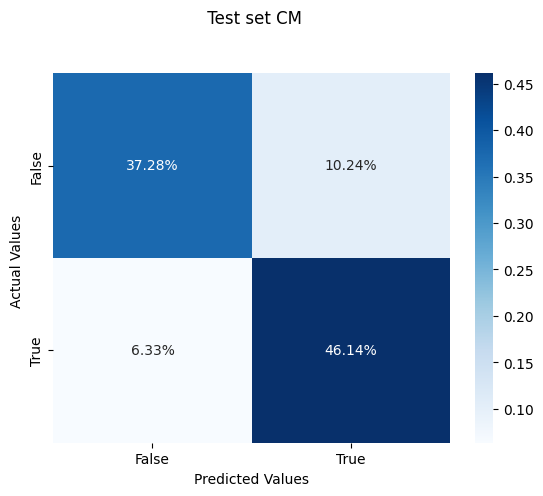

In [11]:
plt.rcParams.update({'font.size': 10})
fig1=plt.figure()
cm = confusion_matrix(y_true=ydt_test, y_pred=y_pred)

ax = sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title(' Test set CM\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


fig1 = ax.get_figure()
fig1.savefig('RF_frdcl_tr4_tetra.pdf', dpi=400)

In [ ]:
client = Client(processes=False, threads_per_worker=1, n_workers=64, memory_limit='256GB')

In [13]:
start_time=time.time()


# Scatter X data to workers
Xdt_test_dask = client.scatter(Xdt_test, broadcast=True)
# Scatter y data to workers
ydt_test_dask = client.scatter(ydt_test, broadcast=True)  


@dask.delayed
def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    return result

# Compute permutation importance with Dask delayed computation
perm_importance_delayed = compute_permutation_importance(rfc_tetra, Xdt_test_dask, ydt_test_dask)

# Compute the result
perm_importance_t3 = perm_importance_delayed.compute()


end_time=time.time()
total_time=end_time-start_time
print("execution time",total_time,"s")

/mnt/pixstor/data/tsrbcx/miniconda/envs/sickt_ml/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.54 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


execution time 18798.8190677166 s


In [ ]:
client.close()

In [15]:
sorted_idx = perm_importance_t3.importances_mean.argsort()
top_fidx=sorted_idx[-22:]

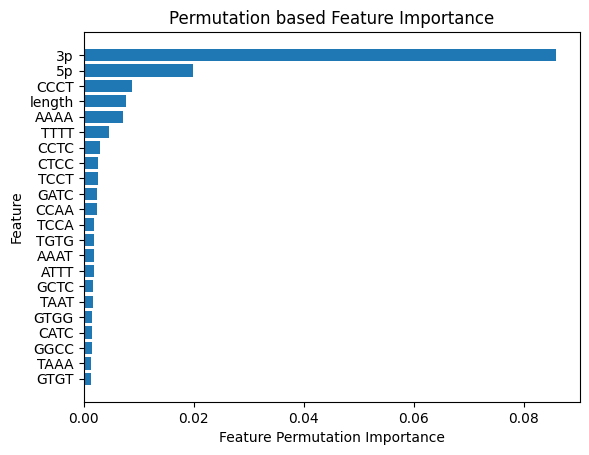

In [16]:
plt.rcParams.update({'font.size': 10})
fig4=plt.figure()
plt.barh(Xdt_train.columns[top_fidx], perm_importance_t3.importances_mean[top_fidx])
plt.xlabel("Feature Permutation Importance")
plt.ylabel('Feature')
plt.title('Permutation based Feature Importance')
fig4.savefig("Permutation_based_FI_t4_frdcl_tr4.pdf")

In [8]:
t4_fe=['5p','3p','CCCT','length','AAAA']

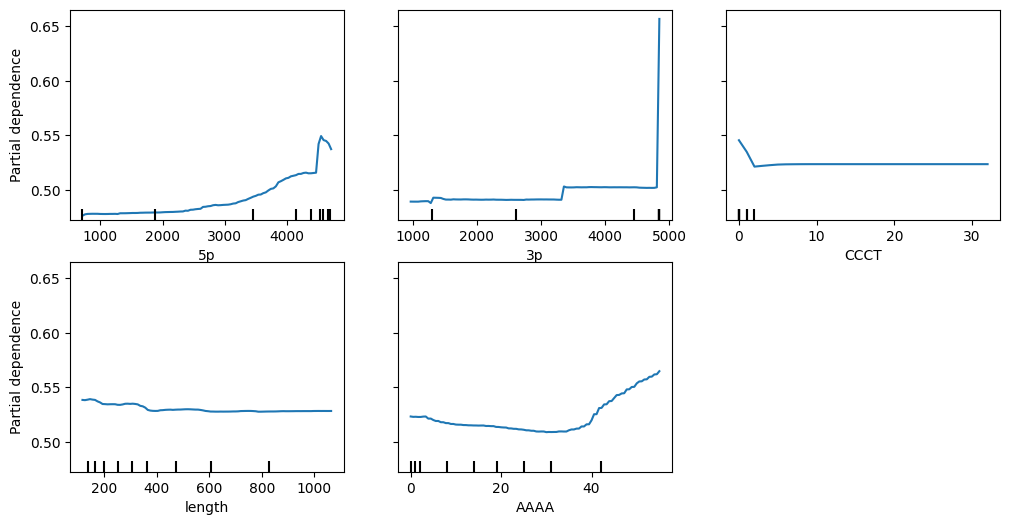

In [9]:
fig2, ax = plt.subplots(figsize=(12, 6))

tree_disp = PartialDependenceDisplay.from_estimator(rfc_tetra,X=Xdt_test,features=t4_fe, ax=ax,n_jobs=64)


In [10]:
fig2.savefig('frdcl_tr4_t4_pdp.pdf',dpi=300)

In [16]:
pdp_results = {}

for i, feature in enumerate(t4_fe):
    print(feature)
    # Ensure the index is within bounds of lines_
    if i < tree_disp.lines_.shape[1]:
        # Extract the line object for the feature
        line = tree_disp.lines_[0, i]  # Extract line for the i-th feature in the first (and only) row
        
        # Get the X-axis (feature values) and Y-axis (PDP values) data from the line object
        feature_values = line.get_xdata()
        pdp_values = line.get_ydata()
        
        # Store the results in the dictionary
        pdp_results[feature] = pd.DataFrame({
            'Feature Value': feature_values,
            'Partial Dependence': pdp_values
        })
    else:
        print(f"Index {i} is out of bounds for lines_")

5p
3p
CCCT
length
Index 3 is out of bounds for lines_
AAAA
Index 4 is out of bounds for lines_


In [15]:
top_pdp_results = {}


for feature, df in pdp_results.items():
    # Sort by partial dependence values and select the top 5
    top_5_pdp = df.nlargest(5, 'Partial Dependence')
    
    # Store the top 5 DataFrame in the dictionary
    top_pdp_results[feature] = top_5_pdp


for feature, top_pdp in top_pdp_results.items():
    print(f"Top 5 Partial Dependence Values for Feature: {feature}")
    print(top_pdp)
    print()

Top 5 Partial Dependence Values for Feature: 5p
    Feature Value  Partial Dependence
95    4549.343434            0.549326
96    4589.757576            0.545606
97    4630.171717            0.544835
98    4670.585859            0.542460
94    4508.929293            0.542033

Top 5 Partial Dependence Values for Feature: 3p
   Feature Value  Partial Dependence
3     146.666667            0.539163
4     156.222222            0.538732
2     137.111111            0.538653
5     165.777778            0.538462
0     118.000000            0.538440



In [ ]:
output_directory = "/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/FR_DCL/train/tr_set4_tetra/"

#if needed creat 
#os.makedirs(output_directory, exist_ok=True)


for feature, top_pdp in top_pdp_results.items():
    # Create a filename using the feature name
    filename = f"{feature}_top_5_pdp.csv"
    
    # Create the full path for the CSV file
    file_path = os.path.join(output_directory, filename)
    
    # Save the DataFrame to a CSV file
    top_pdp.to_csv(file_path, index=False)

    print(f"Saved Top 5 Partial Dependence Values for Feature: {feature} to {file_path}")